# Sramtest flow for sram22 64x4m4w2

In [79]:
import yaml
import os
import matplotlib.pyplot as plt
import numpy as np

sram_type = '64x4m4w2'
design='sramtest'
pdk='sky130'
tools='cm'

dut_instance='mem0'

root_dir=os.path.abspath(f"{os.getcwd()}/../")
build_dir=f"{root_dir}/build-{pdk}-{tools}/{design}"
out_dir=os.path.abspath(f"{os.getcwd()}/../../out")
jpower_reports_dir = f"{out_dir}/jpower-reports/{design}-{pdk}"
generated_src_dir = f"{root_dir}/generated-src"
generated_configs_dir = f"{root_dir}/generated-configs"
bsub="bsub -q normal"
overwrite=True

os.makedirs(generated_src_dir, exist_ok=True)
os.makedirs(generated_configs_dir, exist_ok=True)


In [80]:
def generate_verilog(write_operand):
    tb_name = f"sramtest_tb_{write_operand}"
    with open(f"{root_dir}/generated-templates/sramtest_tb_TEMPLATE.v", 'r') as f:
        test = f.read()
    operand_format = f"4'd{write_operand}"
    test = test.replace(">>OPERAND<<", operand_format)
    test = test.replace("sramtest_tb", tb_name)
    with open(f"{generated_src_dir}/sramtest_tb_{write_operand}.v", 'w') as f:
        f.write(test)
    return tb_name

In [81]:
def generate_config(tb_name, write_operand):
    with open(f"{root_dir}/generated-templates/sramtest_power_conf_TEMPLATE.yml", 'r') as f:
        config = yaml.safe_load(f)

    config['sim.inputs']['tb_name'] = tb_name
    config['sim.inputs']['input_files'] = ['src/sramtest.v', f"{generated_src_dir}/{tb_name}.v"]

    #waveform_path = f"{root_dir}/build-{pdk}-{tools}/sramtest-write-din-{write_operand}/sim-rtl-rundir/output.fsdb"
    waveform_path = f"{build_dir}/sramtest-write-din-{write_operand}/sim-rtl-rundir/output.fsdb"

    config['power.inputs']['tb_name'] = tb_name
    config['power.inputs']['waveforms'] = [waveform_path]
    config['power.inputs']['report_configs'][0]['waveform_path'] = waveform_path

    report_name = f"sram22_{sram_type}-write-din_{write_operand}"
    config['power.inputs']['report_configs'][0]['report_name'] = report_name

    with open(f"{generated_configs_dir}/config_{tb_name}.yml", 'w') as f:
        yaml.dump(config, f, sort_keys=False)
    return report_name

In [82]:
tests = []
hammer_cmds_file = "hammer_cmds"
with open(f"{root_dir}/{hammer_cmds_file}", 'w') as f:
    for i in range(1, 16):
        tb_name = generate_verilog(i)
        report_name = generate_config(tb_name, i)
        cmd = ""
        cmd += f"make sim-rtl POWER_CONF={generated_configs_dir}/config_{tb_name}.yml OBJ_DIR={build_dir}/sramtest-write-din-{i}"
        cmd += " && "
        cmd += f"make redo-power-rtl POWER_CONF={generated_configs_dir}/config_{tb_name}.yml"
        #print(cmd)
        f.write(f"{cmd}\n")
        tests.append(report_name)

In [102]:
dut_instance='mem0'
tests_dict = {t: {} for t in tests}     
for tb_name in tests_dict:
    power_rpt_fpath = f"{build_dir}/power-rtl-rundir/reports/{tb_name}.hier.power.rpt"
    if not os.path.exists(power_rpt_fpath):
        print(power_rpt_fpath)
        continue
    with open(power_rpt_fpath,'r') as f:
        for line in f.readlines():
            if line.strip().endswith(f"/{design}/{dut_instance}") and len(line.split())==5:
                words = line.split()
                tests_dict[tb_name]['leakage_power'] = float(words[0])*1000
                tests_dict[tb_name]['internal_power'] = float(words[1])*1000
                tests_dict[tb_name]['switching_power'] = float(words[2])*1000
                tests_dict[tb_name]['total_power'] = float(words[3])*1000

['sram22_64x4m4w2-write-din_1', 'sram22_64x4m4w2-write-din_10', 'sram22_64x4m4w2-write-din_11', 'sram22_64x4m4w2-write-din_12', 'sram22_64x4m4w2-write-din_13', 'sram22_64x4m4w2-write-din_14', 'sram22_64x4m4w2-write-din_15', 'sram22_64x4m4w2-write-din_2', 'sram22_64x4m4w2-write-din_3', 'sram22_64x4m4w2-write-din_4', 'sram22_64x4m4w2-write-din_5', 'sram22_64x4m4w2-write-din_6', 'sram22_64x4m4w2-write-din_7', 'sram22_64x4m4w2-write-din_8', 'sram22_64x4m4w2-write-din_9']


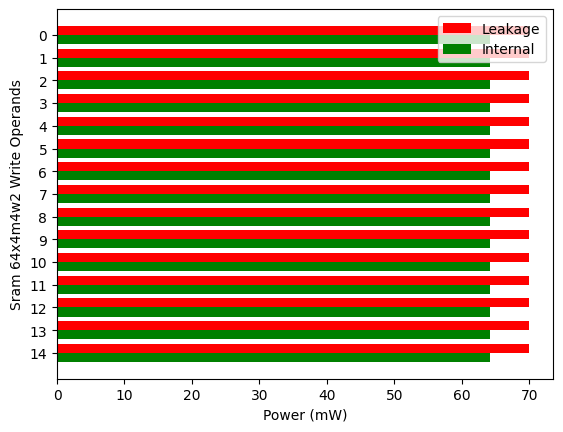

In [145]:
tests_sorted = [t for _,t in sorted([(tests_dict[t]['total_power'],t) for t in tests_dict if 'total_power' in tests_dict[t]])]
power_sorted = [tests_dict[t]['total_power'] for t in tests_sorted]
switching = [tests_dict[t]['switching_power'] for t in tests_sorted]
internal = [tests_dict[t]['internal_power'] for t in tests_sorted]
leakage = [tests_dict[t]['leakage_power'] for t in tests_sorted]

fig, ax = plt.subplots()

y_pos = np.arange(15)

bar_width = 0.4
ax.barh(y_pos - bar_width/2, leakage, bar_width, color='r', label='Leakage')
ax.barh(y_pos + bar_width/2, internal, bar_width, color='g', label='Internal')
ax.set_yticks(y_pos)
ax.invert_yaxis()
ax.set_xlabel('Power (mW)')
ax.set_ylabel('Sram 64x4m4w2 Write Operands')
plt.legend()